In [1]:
# install the required packages first
require(jsonlite)
require(httr)
require(data.table)

get_token <- function(username, password, url_site){
    
    post_body = list(username=username,password=password)
    post_url_string = paste0(url_site,'/token/')
    result = POST(post_url_string, body = post_body)

    # error handling (wrong credentials)
    if(result$status_code==400){
        print('Check your credentials')
        return(0)
    }
    else if (result$status_code==201){
        output = content(result)
        token = output$key
    }

    return(token)
}

get_data <- function(start_date='2020-03-20', token, url_site){
    
    post_body = list(start_date=start_date,username=username,password=password)
    post_url_string = paste0(url_site,'/dataset/')
    
    header = add_headers(c(Authorization=paste('Token',token,sep=' ')))
    result = GET(post_url_string, header, body = post_body)
    output = content(result)
    data = data.table::rbindlist(output)
    data[,event_date:=as.Date(event_date)]
    data = data[order(event_date)]
    return(data)
}


send_submission <- function(predictions, token, url_site, submit_now=F){
    
    format_check=check_format(predictions)
    if(!format_check){
        return(FALSE)
    }
    
    post_string="list("
    for(i in 1:nrow(predictions)){
        if(i<nrow(predictions)){
            post_string=sprintf("%s%s,",post_string,predictions$forecast[i])
        } else {
            post_string=sprintf("%s%s)",post_string,predictions$forecast[i])
        }
    }
    
    submission = eval(parse(text=post_string))
    json_body = jsonlite::toJSON(submission, auto_unbox = TRUE)
    submission=list(submission=json_body)
    
    print(submission)
    # {"31515569":2.4,"32939029":2.4,"4066298":2.4,"6676673":2.4,"7061886":2.4,"85004":2.4} 

    if(!submit_now){
        print("You did not submit.")
        return(FALSE)      
    }
    

    header = add_headers(c(Authorization=paste('Token',token,sep=' ')))
    post_url_string = paste0(url_site,'/submission/')
    result = POST(post_url_string, header, body=submission)
    
    if (result$status_code==201){
        print("Successfully submitted. Below you can see the details of your submission")
    } else {
        print("Could not submit. Please check the error message below, contact the assistant if needed.")
    }
    
    print(content(result))
    
}

check_format <- function(predictions){
    
    if(is.data.frame(predictions) | is.data.frame(predictions)){
        if('forecast' %in% names(predictions)){
            if(nrow(predictions)==24){
                if(all(is.numeric(predictions$forecast))){
                    print("Format OK")
                    return(TRUE)
                } else {
                    print("forecast information is not numeric")
                    return(FALSE)                
                }
            } else {
                print("Forecasts for 24 hours should be provided, current number of rows:")
                print(nrow(predictions))
                return(FALSE)     
            }
        } 
    } else {
        print("Wrong format. Please provide data.frame or data.table object")
        return(FALSE)
    }
    
}

# this part is main code
subm_url = 'http://46.101.124.77'

u_name = "Group10"
p_word = "sSQe4kg1ne5XiB7U"
submit_now = FALSE

username = u_name
password = p_word

token = get_token(username=u_name, password=p_word, url=subm_url)
data = get_data(token=token,url=subm_url)


In [2]:
library(data.table)
library(lubridate)
library(panelaggregation)
library(dplyr)
library(urca)
library(forecast)
library(tidyverse)


Attaching package: 'lubridate'

The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following object is masked from 'package:base':

    date

Warning message:
"package 'panelaggregation' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:lubridate':

    intersect, setdiff, union

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'forecast' was built under R version 3.6.2"Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.fram

In [3]:
data=fread("current_data.csv")

In [4]:
data=data[,c(2:11)]
data$Date=as.Date(data$Date)

In [5]:
# old <- c("event_date", "event_hour", "consumption","t_1","t_2","t_3","t_4","t_5","t_6","t_7")
# new <- c("Date", "Hour", "Consumption","T_1","T_2","T_3","T_4","T_5","T_6","T_7")
# setnames(data, old, new, skip_absent = TRUE)

In [6]:
data=data[order(Date,Hour)]

In [7]:
train=fread("bulk_consumption_with_temp.csv")
train$Date=as.Date(train$Date)

In [8]:
all_dt=rbind(train,data)

In [164]:
getwd()

[1] "C:/Users/bahad/GitHub/360project/R Code/bahadir_work/New Model"

## Performance Measure

Performance measures will be made by calling the perf_dt() function. In this function, name of the model(with details), how many numbers of observation is evaluated, mean, standard deviation, daily bias, daily mean absolute percentage error, root mean square error, mean absolute deviation, and weighted mean absolute percentage error. Namely, this function will return all the demanded performance measures in the homework description, but also additional beneficial information related to model performance.

In [9]:
perf_dt=function(type,actual,forecast){
    name=type
    n=length(actual)
    error=actual-forecast
    mean=mean(actual)
    sd=sd(actual)
    FBias=sum(error)/sum(actual)
    MPE=sum(error/actual)/n
    MAPE=sum(abs(error/actual))/n
    RMSE=sqrt(sum(error^2))/n
    MAD=sum(abs(error))/n
    WMAPE=MAD/mean
    l=data.frame(name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE)
    return(l)
}

In [10]:
setnames(all_dt,"Date","date")
setnames(all_dt,"Consumption","consumption")
setnames(all_dt,"Hour","hour")

### Group all the dataset by daily

In [11]:
df =all_dt %>% 
  group_by(date) %>% 
  summarise(consumption = mean(consumption))
dt=as.data.table(df)

`summarise()` ungrouping output (override with `.groups` argument)


### Seperating Dataset 

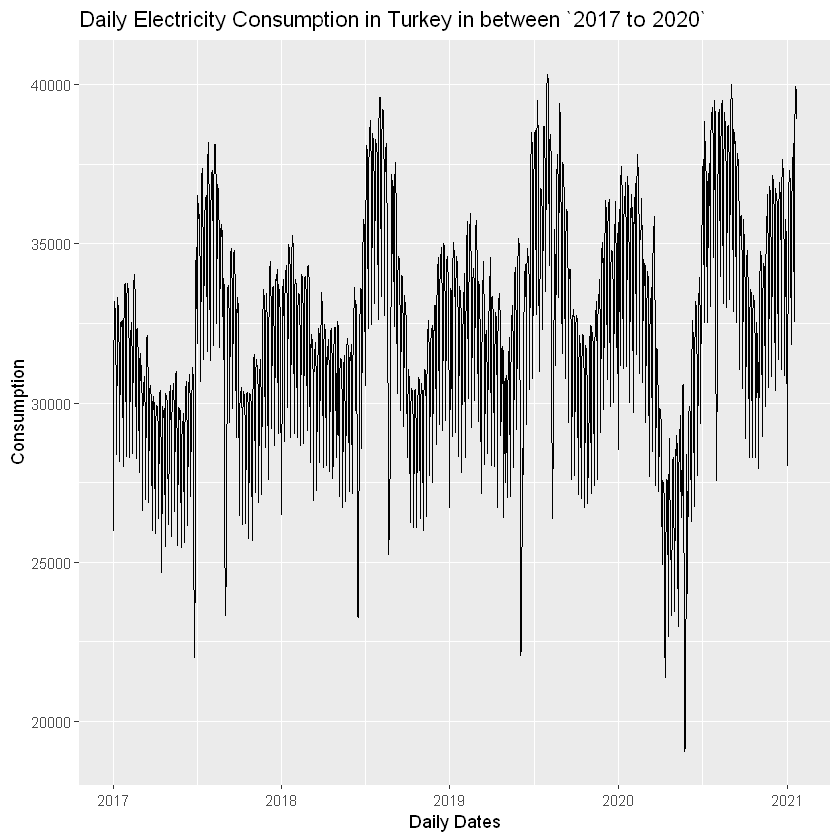

In [97]:
ggplot(dt[1:(.N-10)], aes(x=date, y=consumption))+geom_line()+labs(title="Daily Electricity Consumption in Turkey in between `2017 to 2020`")+
                                                                   ylab("Consumption")+xlab("Daily Dates")

In [12]:
train=filter(dt,date<="2021-01-07")
test=filter(dt,date>"2021-01-07")

### Dataframe to Time-Series Object

In [13]:
train_ts=ts(train$consumption,freq=7)
test_ts=ts(test$consumption,freq=7)

# Feature DF

In [14]:
feat_dt=fread("C:/Users/bahad/GitHub/360project/all_features_df.csv")
feat_dt$date=as.Date(feat_dt$date)

In [15]:
feat_dt[holiday_val_factor==8,holiday_val_factor:=0]

In [16]:
train_feat=merge(train,feat_dt[,c(1,2)],by.x="date",by.y="date")
#train_feat[out_and$index][holiday_val_factor==0]$holiday_val_factor=8

In [17]:
train_feat$month=month(train_feat$date)

In [18]:
train_feat[,year_day:=yday(date)]
train_feat[,week_day:=wday(date)]
train_feat[,lag_7:=shift(consumption, 7)]
train_feat[,lag_14:=shift(consumption, 14)]
train_feat[,for_14:=shift(consumption, type="lead", 14)]
train_feat[,for_7:=shift(consumption, type="lead", 7)]
train_feat[, lag_365:=shift(consumption, 364)]

### New year

In [19]:
train_feat[holiday_val_factor==1,consumption:=lag_7]
train_feat[1]$consumption=train_feat[8]$consumption

In [20]:
train_feat[year_day==366]$consumption=train_feat[year_day==366]$lag_7

In [21]:
train_feat[year_day==365]$consumption=train_feat[year_day==365]$lag_7

##### Lackdown and new year 2021

In [22]:
train_feat[date=="2021-01-02", consumption:=lag_7]

# Holiday Factor == 8

### 2017 Ramadan Change

In [23]:
train_feat[date<"2017-07-02" & date>="2017-06-23" & holiday_val_factor==0,holiday_val_factor:=8]

### 2017 Zafer Bayrami

In [24]:
train_feat[date=="2017-08-29", holiday_val_factor:=8] 

### 2019 Zafer Bayrami

In [25]:
train_feat[date=="2019-08-31", holiday_val_factor:=8] 

### 2018 Kurban Bayramı

In [26]:
train_feat[date<"2018-08-27" & date>="2018-08-18" & holiday_val_factor==0,holiday_val_factor:=8]

### 2019 Ramazan Bayramı

In [27]:
train_feat[date<"2019-06-10" & date>="2019-06-01" & holiday_val_factor==0,holiday_val_factor:=8]

### 2019 Kurban Bayramı

In [28]:
train_feat[date<"2019-08-19" & date>="2019-08-10" & holiday_val_factor==0,holiday_val_factor:=8]

### New Year Holiday Before

In [29]:
train_feat[date=="2019-12-29",holiday_val_factor:=8]

### Verilen 3 haftalık tatilin ilk haftası (haftaiçi)

In [30]:
train_feat[date<="2020-03-20" & date>="2020-03-16" & holiday_val_factor==0,holiday_val_factor:=8]

### 2020 Kurban Bayramı ????????

In [31]:
# train_feat[date>="2020-07-10" & date<="2020-08-15",]

# Lag364 Holiday==9

### İlk dönem haftasonu lackdown durumu

In [32]:
train_feat[date>="2020-04-01"&date<="2020-05-31"& (week_day==1|week_day==7) & holiday_val_factor==0,holiday_val_factor:=9]

# Adjustment

In [33]:
for(i in 2:8){
    for(j in 1:nrow(train_feat[holiday_val_factor==i,])){
        new_val=0
        count=0
#         if(train_feat[date==train_feat[holiday_val_factor==i,][j]$date+14]$holiday_val_factor==0){
#             new_val=new_val+train_feat[holiday_val_factor==i,][j]$for_14
#             count=count+1
#         }
        if(train_feat[date==train_feat[holiday_val_factor==i,][j]$date+7]$holiday_val_factor==0){
            new_val=new_val+train_feat[holiday_val_factor==i,][j]$for_7+train_feat[holiday_val_factor==i,][j]$for_7
            count=count+2
        }
        if(train_feat[date==train_feat[holiday_val_factor==i,][j]$date-7]$holiday_val_factor==0){
            new_val=new_val+train_feat[holiday_val_factor==i,][j]$lag_7+train_feat[holiday_val_factor==i,][j]$lag_7
            count=count+2
        }
        if(train_feat[date==train_feat[holiday_val_factor==i,][j]$date+14]$holiday_val_factor==0){
            new_val=new_val+train_feat[holiday_val_factor==i,][j]$lag_14
            count=count+1
        }
        new_val=new_val/count
        train_feat[holiday_val_factor==i,][j]$consumption=new_val        
    }
}

### Holiday 9

In [34]:
train_feat[holiday_val_factor==9 & week_day==7, consumption:=consumption+1500]

# 19 Mayıs Zamanı Yapılan Sokağa Çıkma düzeltmesi

In [35]:
train_feat[date=="2020-05-16"|date=="2020-05-17",consumption:=lag_7]

In [36]:
# diff_sun=train_feat[date>="2019-04-01"&date<="2019-06-05" & (week_day==1), ]$consumption-train_feat[date>="2020-04-01"&date<="2020-05-31" & (week_day==1), ]$consumption
# diff_sat=train_feat[date>="2019-04-01"&date<="2019-06-05" & (week_day==7), ]$consumption-train_feat[date>="2020-04-01"&date<="2020-05-31" & (week_day==7), ]$consumption

In [37]:
# diff_sun
# summary(diff_sun)

In [38]:
# diff_sat
# summary(diff_sat)

In [39]:
# diff=train_feat[date>="2019-04-01"&date<="2019-05-31" & (week_day!=1 & week_day!=7), ]$consumption-train_feat[date>="2020-04-01"&date<="2020-06-02" & (week_day!=1 & week_day!=7), ]$consumption

In [40]:
# summary(diff)

In [41]:
# diff

### Outlier Check

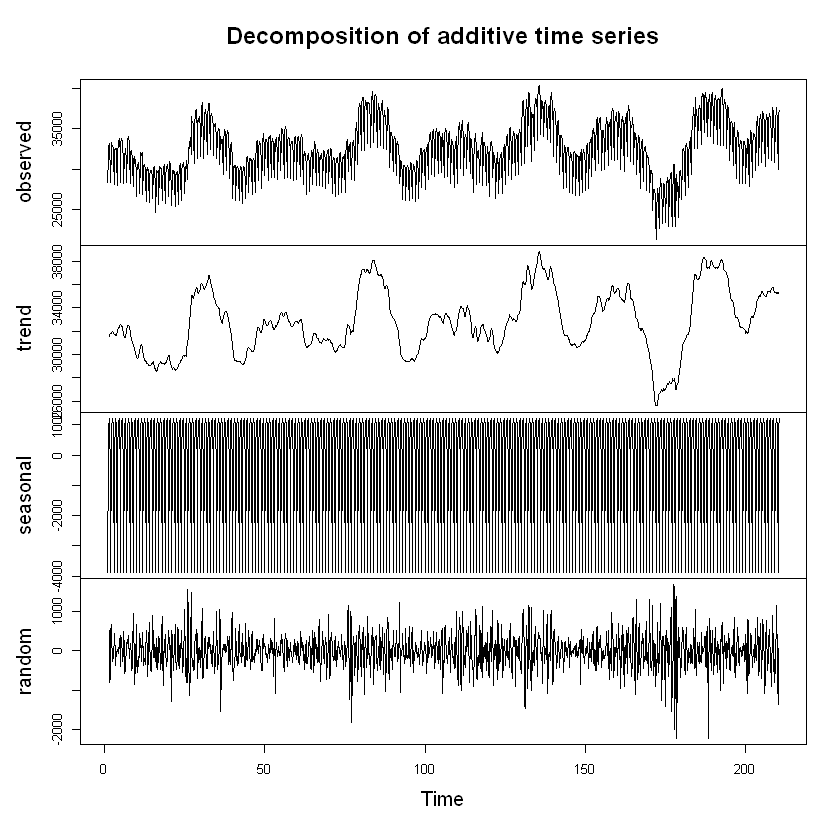

In [42]:
last_decomp=decompose(ts(train_feat$consumption,freq=7),type='add')
plot(last_decomp)

## Last Adjustment for Outliers

In [43]:
out_new<-tsoutliers(last_decomp$random)

In [44]:
# sub_decomp_new=decompose(ts(train_feat$consumption,freq=7),type='add')
# plot(sub_decomp_new)

In [45]:
# plot(train_feat[date>="2020-01-01"&date<="2021-01-30"& (week_day==7),]$date,
#      train_feat[date>="2020-01-01"&date<="2021-01-30"& (week_day==7),]$consumption,type="l")

In [46]:
# plot(train_feat[date>="2020-01-01"&date<="2021-01-30"& (week_day==1),]$date,
#      train_feat[date>="2020-01-01"&date<="2021-01-30"& (week_day==1),]$consumption,type="l")

In [47]:
# train_feat[date<="2021-01-30"& month== 4 & (week_day==7),mean(consumption),by=year(date)]

In [48]:
# train_feat[date<="2021-01-30"& month== 5 & (week_day==7),mean(consumption),by=year(date)]

In [49]:
# plot(train_feat[date<="2021-01-30"& (week_day==7) & holiday_val_factor==0,]$date,
#      train_feat[date<="2021-01-30"& (week_day==7)& holiday_val_factor==0,]$consumption,type="l")

In [50]:
# plot(train_feat[date<="2021-01-30"& (week_day==7) & holiday_val_factor==0,]$date,
#      train_feat[date<="2021-01-30"& (week_day==7)& holiday_val_factor==0,]$consumption,type="l")

In [51]:
unt_test_final=ur.kpss(last_decomp$random) 
summary(unt_test_final)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 7 lags. 

Value of test-statistic is: 0.0069 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


In [99]:
Box.test(last_decomp$random, lag=10, type="Ljung-Box")


	Box-Ljung test

data:  last_decomp$random
X-squared = 743.65, df = 10, p-value < 2.2e-16


In [52]:
pred_dt=rbind(train_feat,test, fill=TRUE) 
pred_dt=pred_dt[,c(1,2)]
pred_dt=as.data.table(pred_dt)

In [53]:
pred_dt

date,consumption
2017-01-01,28388.02
2017-01-02,31293.86
2017-01-03,32666.97
2017-01-04,33190.91
2017-01-05,32824.98
2017-01-06,31913.98
2017-01-07,30526.69
2017-01-08,28388.02
2017-01-09,32672.65
2017-01-10,33323.62


# ARIMA Models

In [54]:
fitted=auto.arima(last_decomp$random,trace=T)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2)(1,0,1)[7] with non-zero mean : Inf
 ARIMA(0,0,0)           with non-zero mean : 21964.84
 ARIMA(1,0,0)(1,0,0)[7] with non-zero mean : 21779.02
 ARIMA(0,0,1)(0,0,1)[7] with non-zero mean : 21726.25
 ARIMA(0,0,0)           with zero mean     : 21962.83
 ARIMA(0,0,1)           with non-zero mean : 21771.95
 ARIMA(0,0,1)(1,0,1)[7] with non-zero mean : 21696.12
 ARIMA(0,0,1)(1,0,0)[7] with non-zero mean : 21711.95
 ARIMA(0,0,1)(2,0,1)[7] with non-zero mean : 21698.16
 ARIMA(0,0,1)(1,0,2)[7] with non-zero mean : 21697.97
 ARIMA(0,0,1)(0,0,2)[7] with non-zero mean : 21711.65
 ARIMA(0,0,1)(2,0,0)[7] with non-zero mean : 21704.45
 ARIMA(0,0,1)(2,0,2)[7] with non-zero mean : 21700.18
 ARIMA(0,0,0)(1,0,1)[7] with non-zero mean : 21868.39
 ARIMA(1,0,1)(1,0,1)[7] with non-zero mean : 21697.12
 ARIMA(0,0,2)(1,0,1)[7] with non-zero mean : 21615.2
 ARIMA(0,0,2)(0,0,1)[7] with non-zero mean : 21610.69
 ARIMA(0,0,2)           wit

In [55]:
fitted

Series: last_decomp$random 
ARIMA(0,0,2)(1,0,0)[7] with non-zero mean 

Coefficients:
          ma1      ma2    sar1     mean
      -0.2687  -0.6777  0.1249  -0.0348
s.e.   0.0181   0.0166  0.0284   0.6382

sigma^2 estimated as 152788:  log likelihood=-10799.46
AIC=21608.92   AICc=21608.96   BIC=21635.35

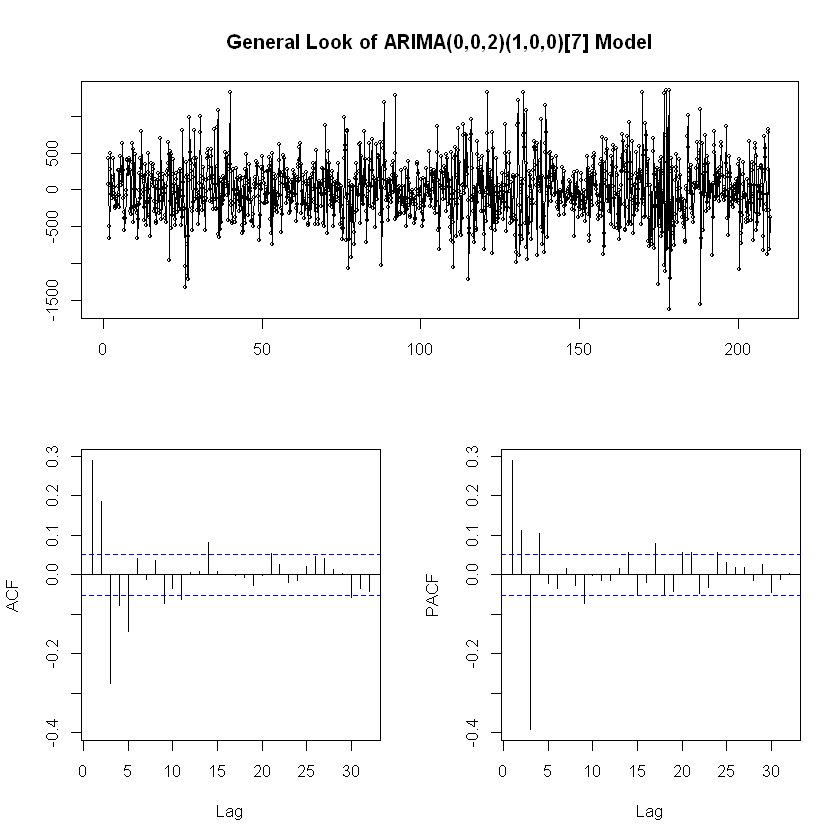

In [56]:
tsdisplay(residuals(fitted),main="General Look of ARIMA(0,0,2)(1,0,0)[7] Model")

In [57]:
fitted_new=arima(last_decomp$random,order=c(3,0,2),seasonal = c(0,0,1))
fitted_new


Call:
arima(x = last_decomp$random, order = c(3, 0, 2), seasonal = c(0, 0, 1))

Coefficients:
         ar1     ar2      ar3      ma1      ma2    sma1  intercept
      0.1212  0.3914  -0.4867  -0.0875  -0.8533  0.1125    -0.0177
s.e.  0.0653  0.0653   0.0358   0.0649   0.0649  0.0278     0.6172

sigma^2 estimated as 116806:  log likelihood = -10605.32,  aic = 21226.63

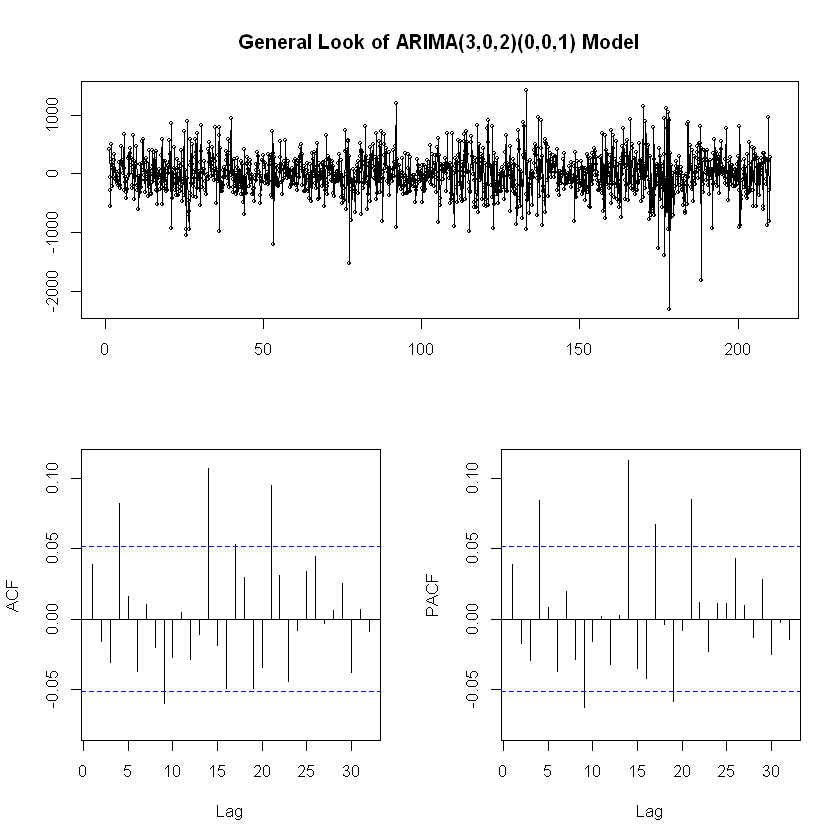

In [58]:
tsdisplay(residuals(fitted_new),main="General Look of ARIMA(3,0,2)(0,0,1) Model")

# Predictions

In [59]:
pred_dt=rbind(train_feat,test,fill=TRUE)
pred_dt=pred_dt[,c(1,2)]
pred_dt=as.data.table(pred_dt)

In [60]:
str(pred_dt)

Classes 'data.table' and 'data.frame':	1493 obs. of  2 variables:
 $ date       : Date, format: "2017-01-01" "2017-01-02" ...
 $ consumption: num  28388 31294 32667 33191 32825 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [61]:
# write.csv(data,"current_data.csv")

In [62]:
test_start=as.Date("2021-01-08")

results=vector("list",14)

for(i in 1:14){
    current_test_date=test_start+i
    train_data=pred_dt[date<current_test_date]
    test_data=pred_dt[date==current_test_date]
    print(current_test_date)
    decomp=decompose(ts(train_data$consumption,freq=7),type="add")
    rand_val=decomp$random
    fit_mod=arima(rand_val, order=c(3,0,2), seasonal = list(order = c(0, 0, 1), period = 7))
    test_data[,forecasted:=as.numeric(predict(fit_mod, n.ahead = 1)$pred + decomp$season[wday(current_test_date)] +
                                     tail(decomp$trend[!is.na(decomp$trend)],1))]
    results[[i+1]]=test_data
}

[1] "2021-01-09"
[1] "2021-01-10"
[1] "2021-01-11"
[1] "2021-01-12"
[1] "2021-01-13"
[1] "2021-01-14"
[1] "2021-01-15"
[1] "2021-01-16"
[1] "2021-01-17"
[1] "2021-01-18"
[1] "2021-01-19"
[1] "2021-01-20"
[1] "2021-01-21"
[1] "2021-01-22"


In [63]:
res_dt=rbindlist(results)

In [64]:
# res_dt

In [65]:
perf_dt("Predictions in Arima with Slicing Window", res_dt$consumption, res_dt$forecasted)

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Predictions in Arima with Slicing Window,14,37045.79,2567.339,0.01961258,0.01901392,267.0696,728.0602,0.01965298


# Residual Check

In [66]:
feature_cont=read.csv("C:/Users/bahad/GitHub/360project/all_features_df.csv")
feature_cont=as.data.table(feature_cont)
feature_cont$date=as.Date(feature_cont$date)
temp_all=fread("bulk_consumption_with_temp.csv")
temp_all$Date=as.Date(temp_all$Date)
temp_all=rbind(temp_all, data)

In [67]:
temp_df =temp_all %>% 
  group_by(Date) %>% 
  summarise(consumption = mean(Consumption),
            reduced_tmp = mean(0.3794502 * T_1 + 
                          0.3748089 * T_2 + 0.3782977 * T_3 + 
                          0.3800144 * T_4 + 0.3790882 * T_5 + 
                          0.3803995 * T_6 + 0.3736363 * T_7),
            reduced_tmp_max = max(0.3794502 * T_1 + 
                          0.3748089 * T_2 + 0.3782977 * T_3 + 
                          0.3800144 * T_4 + 0.3790882 * T_5 + 
                          0.3803995 * T_6 + 0.3736363 * T_7),
            reduced_tmp_min = min(0.3794502 * T_1 + 
                          0.3748089 * T_2 + 0.3782977 * T_3 + 
                          0.3800144 * T_4 + 0.3790882 * T_5 + 
                          0.3803995 * T_6 + 0.3736363 * T_7)
           )
temp_dt=as.data.table(temp_df)


`summarise()` ungrouping output (override with `.groups` argument)


In [75]:
final_feat_dt=merge(feature_cont[,c(1,4,5,6,7,8,9)],temp_dt[, c(1,2,3,4,5)],by.x="date", by.y="Date")

In [103]:
tail(final_feat_dt)

date,month_factor,lock_down_factor,covid_severity,sunlight_time_minutes,production_capacity_rate,price_of_electricity,consumption,reduced_tmp,reduced_tmp_max,reduced_tmp_min
2021-01-27,1,1,37.21307,596,75.4,55.1544,38511.21,16.235009,22.982317,6.759384398
2021-01-28,1,1,38.97561,598,75.4,55.1544,39299.42,3.809815,9.291755,-0.005150026
2021-01-29,1,1,30.62915,599,75.4,55.1544,39057.30,2.670273,11.131276,-3.751004985
2021-01-30,1,2,26.73554,602,75.4,55.1544,35959.29,9.106372,17.487340,1.807828270
2021-01-31,1,2,26.15802,604,75.4,55.1544,-1.00,14.954697,25.233207,7.681600213
2021-02-01,2,1,30.36288,606,75.5,55.1544,-1.00,19.753408,31.624954,12.415641098


In [77]:
str(final_feat_dt)

Classes 'data.table' and 'data.frame':	1493 obs. of  11 variables:
 $ date                    : Date, format: "2017-01-01" "2017-01-02" ...
 $ month_factor            : num  1 1 1 1 1 1 1 1 1 1 ...
 $ lock_down_factor        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ covid_severity          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sunlight_time_minutes   : int  558 558 559 560 561 562 563 564 565 567 ...
 $ production_capacity_rate: num  77 77 77 77 77 77 77 77 77 77 ...
 $ price_of_electricity    : num  20.5 20.5 20.5 20.5 20.5 ...
 $ consumption             : num  25975 31294 32667 33191 32825 ...
 $ reduced_tmp             : num  -11.83 -7.656 -7.598 -0.709 10.211 ...
 $ reduced_tmp_max         : num  5.18 4.15 10.53 13.48 15.04 ...
 $ reduced_tmp_min         : num  -20.18 -14.48 -16 -11.94 4.19 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr "date"


In [100]:
lm1 =lm(consumption~.-date, data=final_feat_dt)
summary(lm1)
lm1_step=step(lm1)
summary(lm1_step)


Call:
lm(formula = consumption ~ . - date, data = final_feat_dt)

Residuals:
   Min     1Q Median     3Q    Max 
-33354  -1823    100   2102   7556 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               6331.084   3227.132   1.962 0.049969 *  
month_factor              -221.672     33.661  -6.585 6.28e-11 ***
lock_down_factor         -2339.970    262.303  -8.921  < 2e-16 ***
covid_severity              30.699      6.336   4.845 1.40e-06 ***
sunlight_time_minutes       -7.360      1.651  -4.459 8.87e-06 ***
production_capacity_rate   365.765     33.488  10.922  < 2e-16 ***
price_of_electricity       108.292     10.250  10.565  < 2e-16 ***
reduced_tmp                401.203    124.628   3.219 0.001313 ** 
reduced_tmp_max           -215.626     58.750  -3.670 0.000251 ***
reduced_tmp_min           -109.576     71.155  -1.540 0.123784    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3244 

Start:  AIC=24150.27
consumption ~ (date + month_factor + lock_down_factor + covid_severity + 
    sunlight_time_minutes + production_capacity_rate + price_of_electricity + 
    reduced_tmp + reduced_tmp_max + reduced_tmp_min) - date

                           Df  Sum of Sq        RSS   AIC
<none>                                   1.5604e+10 24150
- reduced_tmp_min           1   24952841 1.5629e+10 24151
- reduced_tmp               1  109043424 1.5713e+10 24159
- reduced_tmp_max           1  141740858 1.5746e+10 24162
- sunlight_time_minutes     1  209171414 1.5813e+10 24168
- covid_severity            1  247009263 1.5851e+10 24172
- month_factor              1  456315567 1.6061e+10 24191
- lock_down_factor          1  837369506 1.6442e+10 24226
- price_of_electricity      1 1174579401 1.6779e+10 24257
- production_capacity_rate  1 1255217001 1.6860e+10 24264



Call:
lm(formula = consumption ~ (date + month_factor + lock_down_factor + 
    covid_severity + sunlight_time_minutes + production_capacity_rate + 
    price_of_electricity + reduced_tmp + reduced_tmp_max + reduced_tmp_min) - 
    date, data = final_feat_dt)

Residuals:
   Min     1Q Median     3Q    Max 
-33354  -1823    100   2102   7556 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               6331.084   3227.132   1.962 0.049969 *  
month_factor              -221.672     33.661  -6.585 6.28e-11 ***
lock_down_factor         -2339.970    262.303  -8.921  < 2e-16 ***
covid_severity              30.699      6.336   4.845 1.40e-06 ***
sunlight_time_minutes       -7.360      1.651  -4.459 8.87e-06 ***
production_capacity_rate   365.765     33.488  10.922  < 2e-16 ***
price_of_electricity       108.292     10.250  10.565  < 2e-16 ***
reduced_tmp                401.203    124.628   3.219 0.001313 ** 
reduced_tmp_max           -215.626   

In [137]:
random_dataset$random=last_decomp$random[4:1465]

In [141]:
lm2 =lm(random~.-date-consumption, data=random_dataset)
summary(lm2)
lm2_step=step(lm2)
summary(lm2_step)


Call:
lm(formula = random ~ . - date - consumption, data = random_dataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-2314.0  -254.2    -6.6   241.8  1798.3 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               623.18608  444.83490   1.401  0.16145    
month_factor                0.08054    4.74701   0.017  0.98647    
lock_down_factor         -261.18862   40.72092  -6.414 1.91e-10 ***
covid_severity              1.53490    0.86617   1.772  0.07660 .  
sunlight_time_minutes       0.08863    0.22449   0.395  0.69305    
production_capacity_rate   -5.99249    4.73922  -1.264  0.20627    
price_of_electricity       -0.73387    1.40100  -0.524  0.60049    
reduced_tmp                23.83669   17.18779   1.387  0.16570    
reduced_tmp_max           -22.67990    8.15038  -2.783  0.00546 ** 
reduced_tmp_min             0.79344    9.73308   0.082  0.93504    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Start:  AIC=17763.29
random ~ (date + month_factor + lock_down_factor + covid_severity + 
    sunlight_time_minutes + production_capacity_rate + price_of_electricity + 
    consumption + reduced_tmp + reduced_tmp_max + reduced_tmp_min) - 
    date - consumption

                           Df Sum of Sq       RSS   AIC
- month_factor              1        54 272698369 17761
- reduced_tmp_min           1      1248 272699563 17761
- sunlight_time_minutes     1     29273 272727588 17762
- price_of_electricity      1     51532 272749847 17762
- production_capacity_rate  1    300273 272998588 17763
- reduced_tmp               1    361216 273059531 17763
<none>                                  272698315 17763
- covid_severity            1    589745 273288060 17765
- reduced_tmp_max           1   1454262 274152577 17769
- lock_down_factor          1   7726612 280424927 17802

Step:  AIC=17761.29
random ~ lock_down_factor + covid_severity + sunlight_time_minutes + 
    production_capacity_rate +


Call:
lm(formula = random ~ lock_down_factor + covid_severity + production_capacity_rate + 
    reduced_tmp + reduced_tmp_max, data = random_dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-2302.95  -250.45    -8.72   247.67  1807.14 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               629.561    296.353   2.124   0.0338 *  
lock_down_factor         -260.388     40.563  -6.419 1.85e-10 ***
covid_severity              1.221      0.774   1.578   0.1148    
production_capacity_rate   -5.759      3.839  -1.500   0.1338    
reduced_tmp                25.223      4.853   5.198 2.30e-07 ***
reduced_tmp_max           -22.920      4.354  -5.264 1.62e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 432.9 on 1456 degrees of freedom
Multiple R-squared:  0.04526,	Adjusted R-squared:  0.04198 
F-statistic: 13.81 on 5 and 1456 DF,  p-value: 3.378e-13


## Residual Check

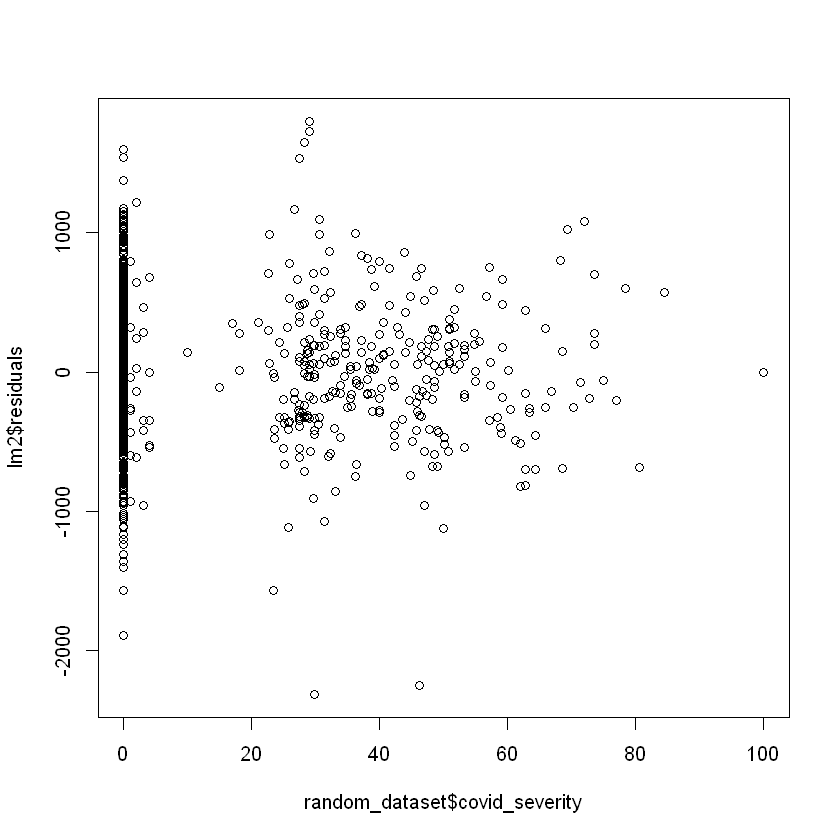

In [142]:
plot(random_dataset$covid_severity, lm2$residuals)

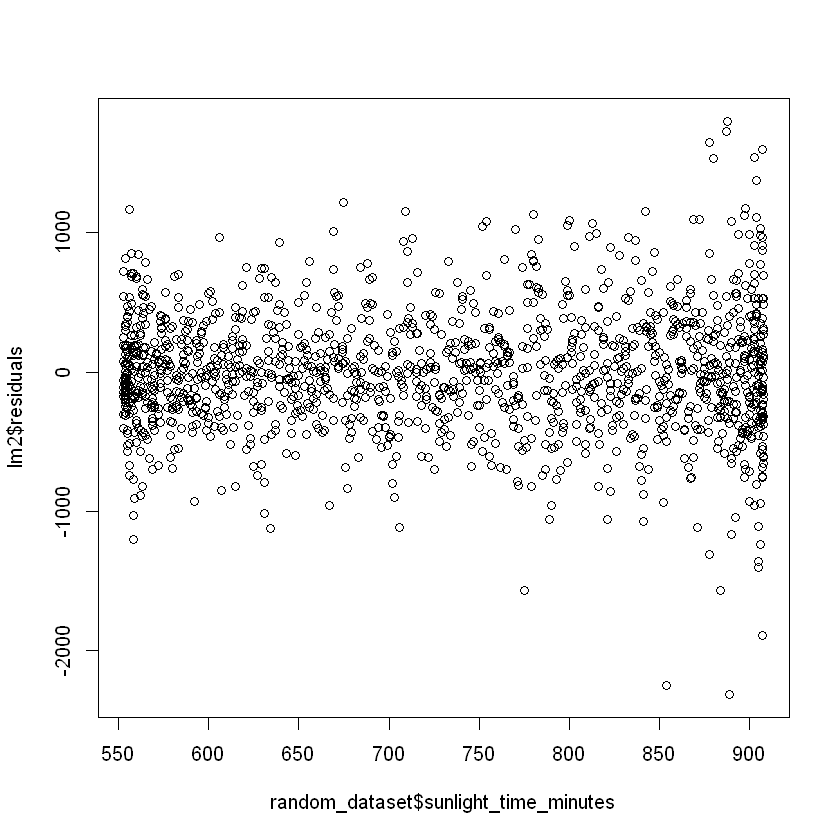

In [143]:
plot(random_dataset$sunlight_time_minutes, lm2$residuals)

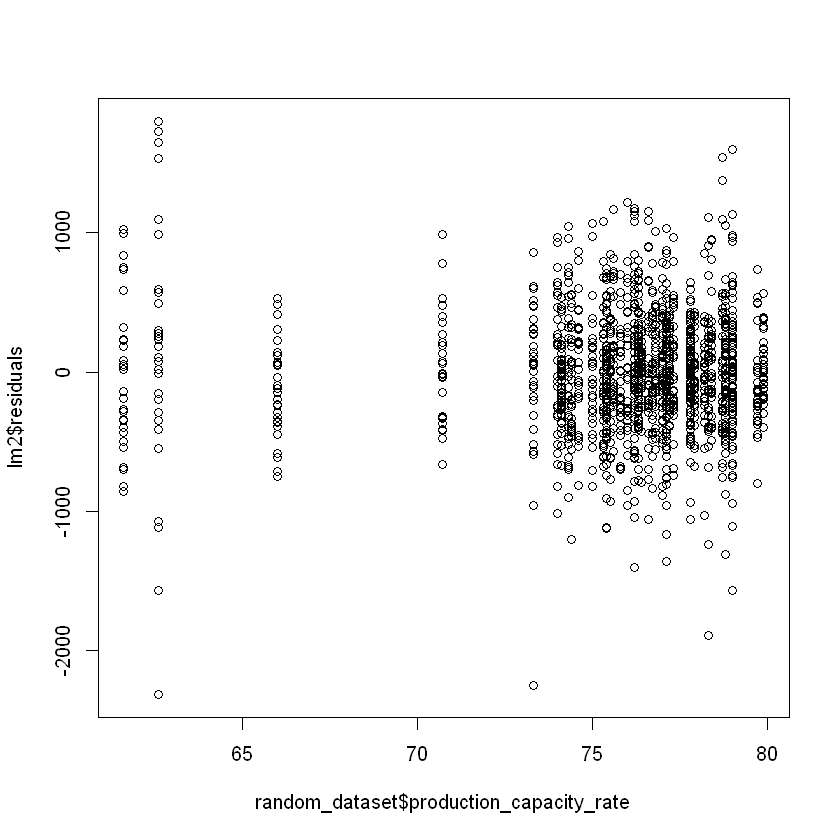

In [156]:
plot(random_dataset$production_capacity_rate, lm2$residuals)

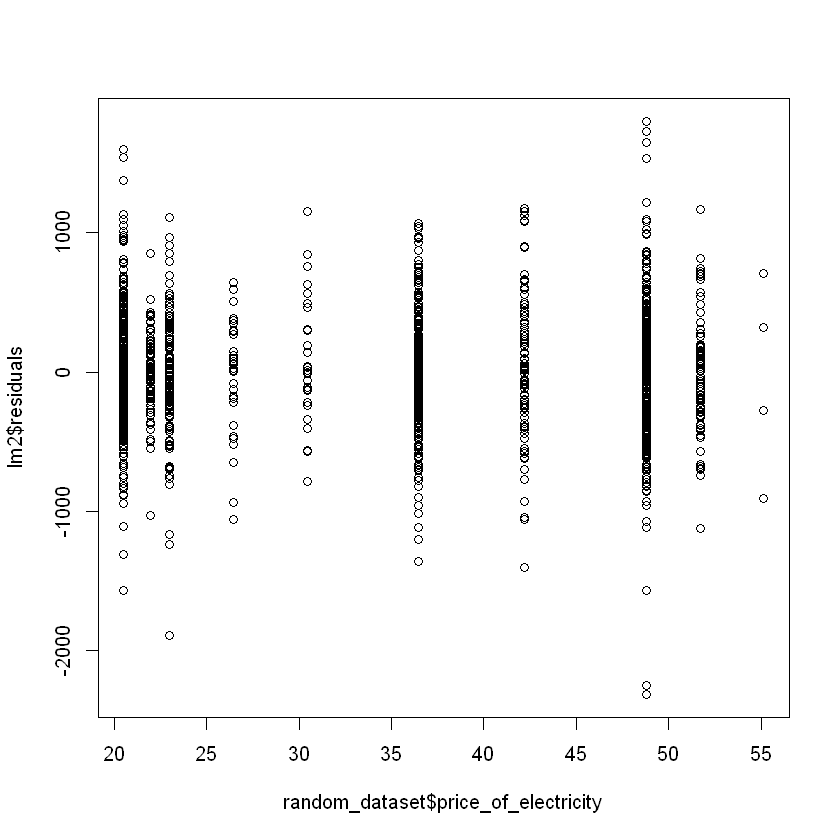

In [157]:
plot(random_dataset$price_of_electricity , lm2$residuals)

In [158]:
plot(random_dataset$usdtry, lm2$residuals)

ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' and 'y' lengths differ


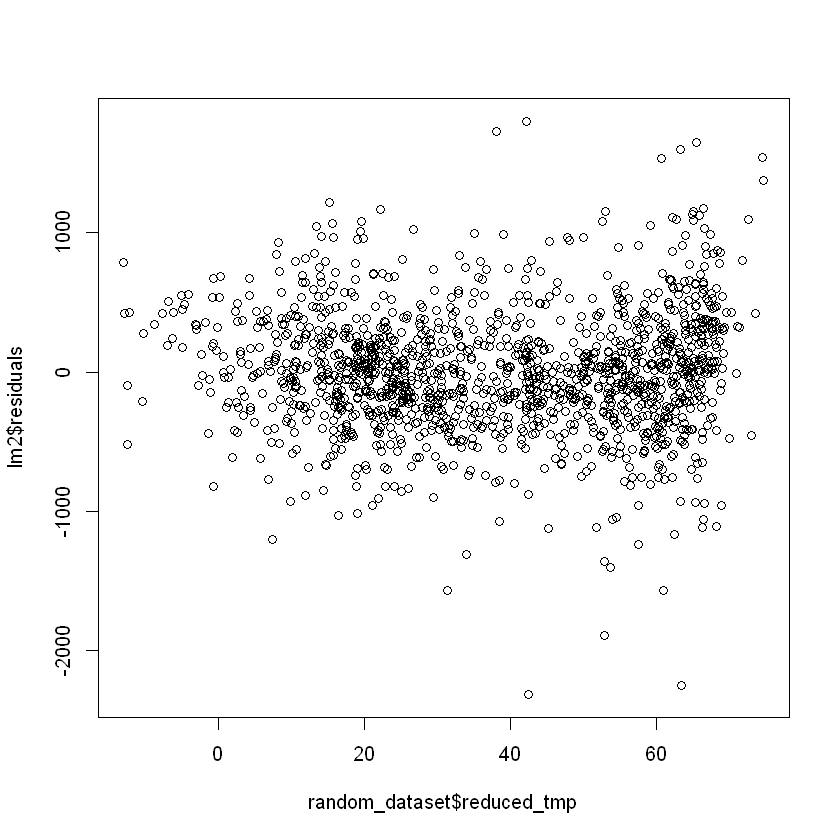

In [159]:
plot(random_dataset$reduced_tmp, lm2$residuals)

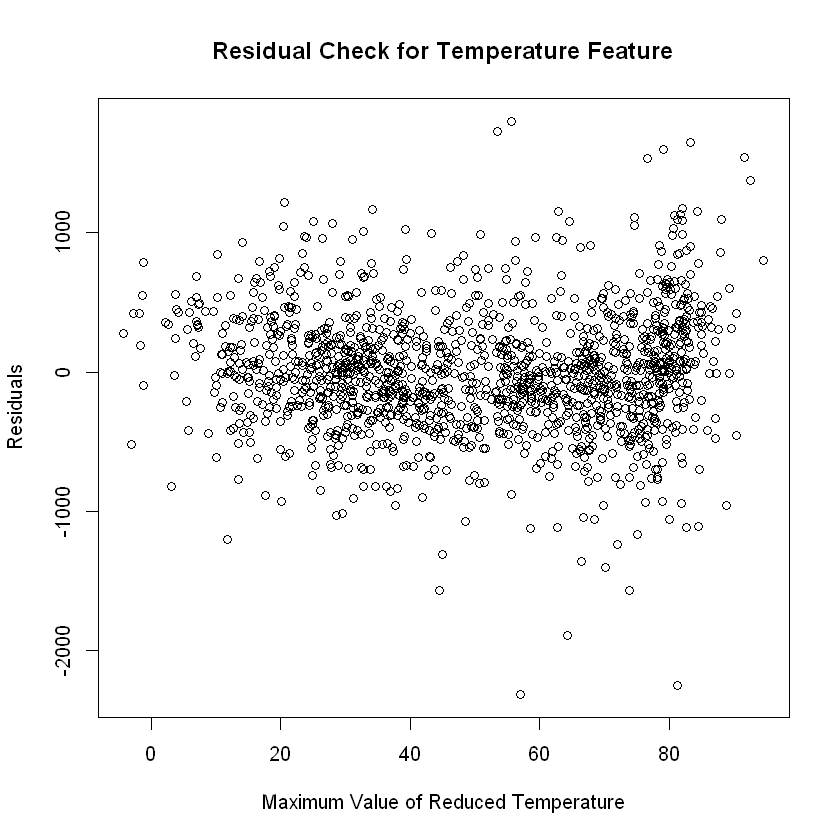

In [163]:
plot(random_dataset$reduced_tmp_max, lm2$residuals, main="Residual Check for Temperature Feature", 
                                                    ylab="Residuals", xlab="Maximum Value of Reduced Temperature")

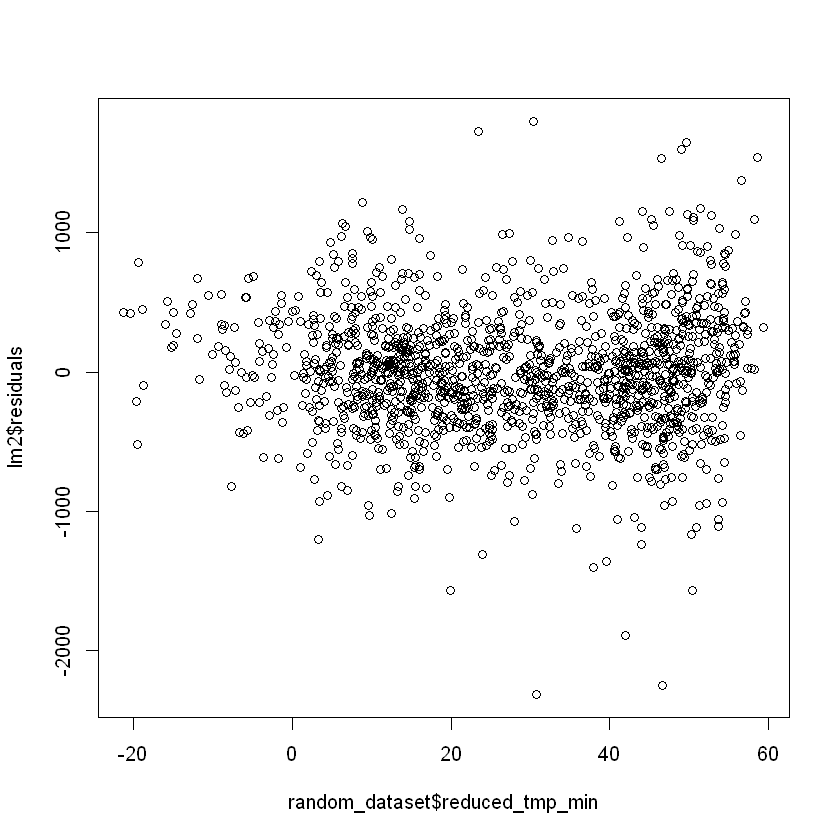

In [161]:
plot(random_dataset$reduced_tmp_min, lm2$residuals)

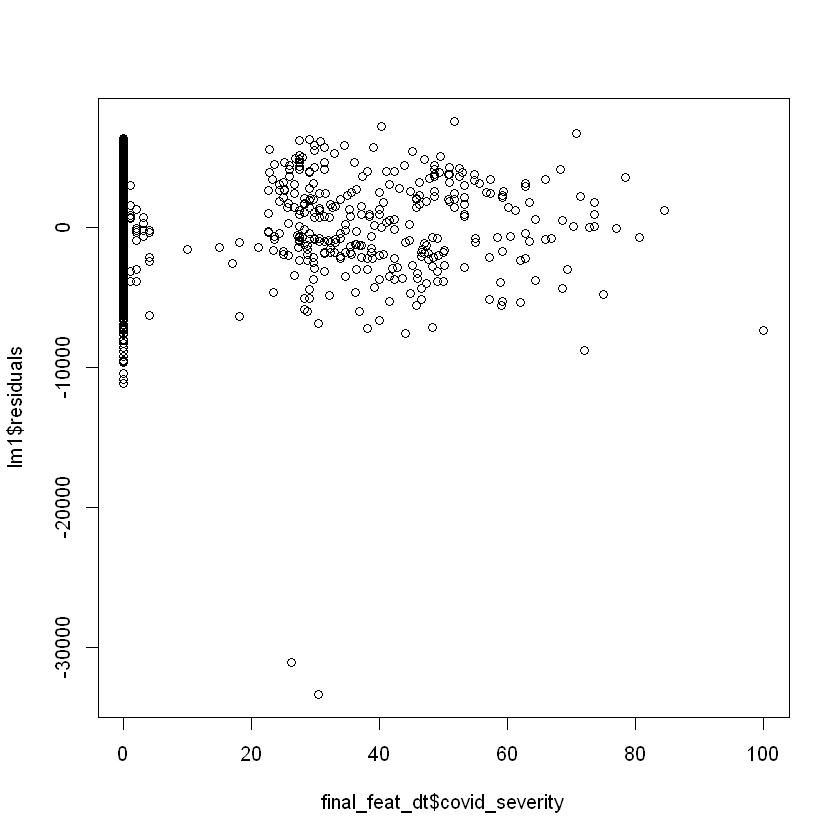

In [162]:
plot(final_feat_dt$covid_severity, lm1$residuals)

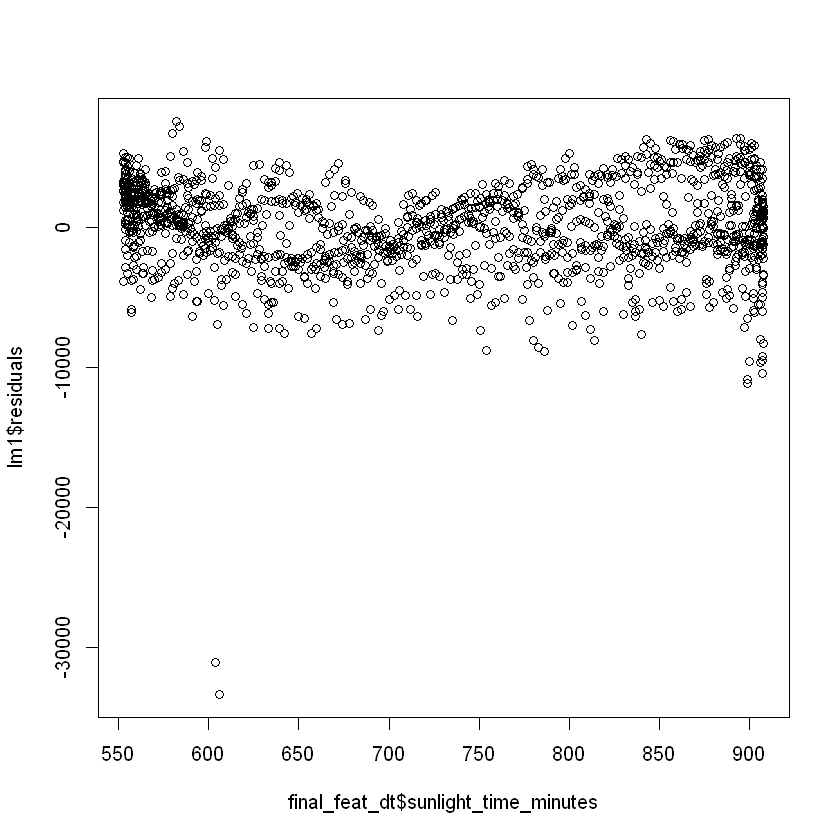

In [148]:
plot(final_feat_dt$sunlight_time_minutes, lm1$residuals)

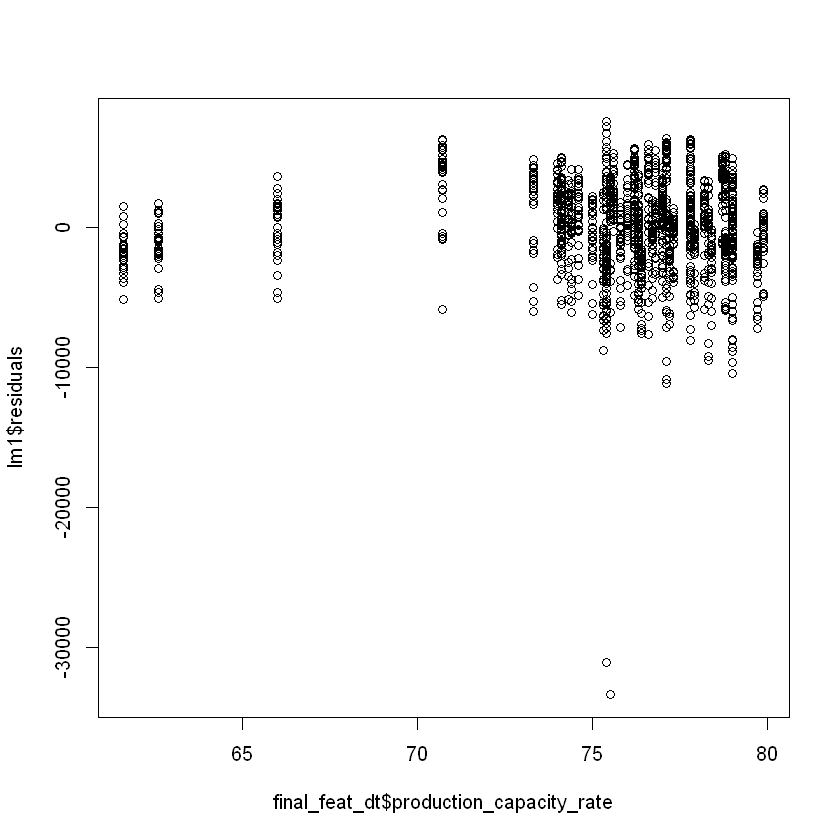

In [149]:
plot(final_feat_dt$production_capacity_rate, lm1$residuals)

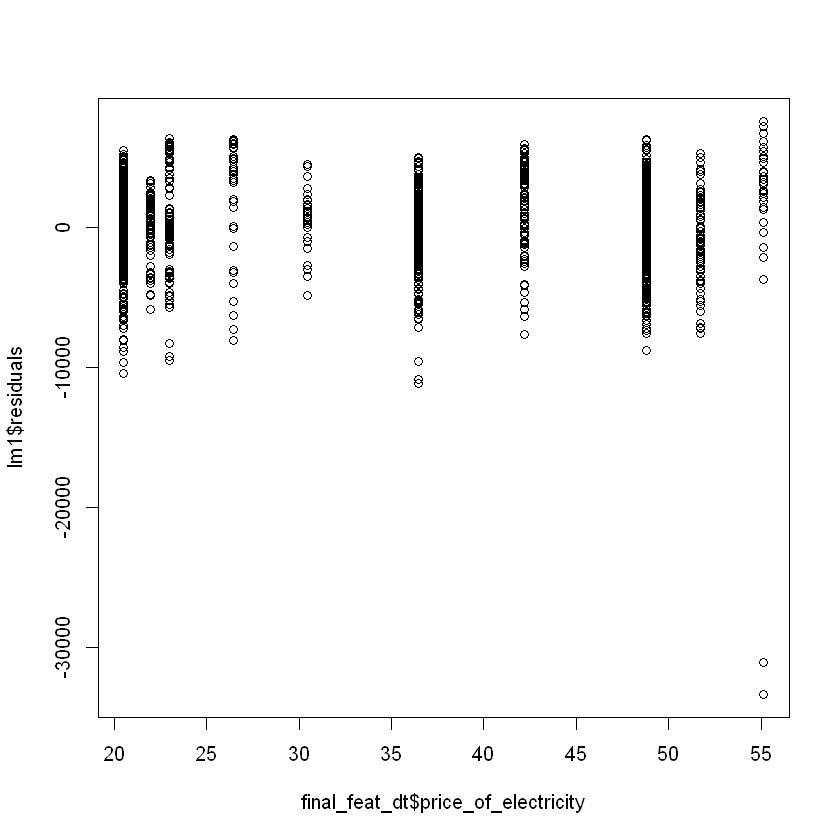

In [150]:
plot(final_feat_dt$price_of_electricity , lm1$residuals)

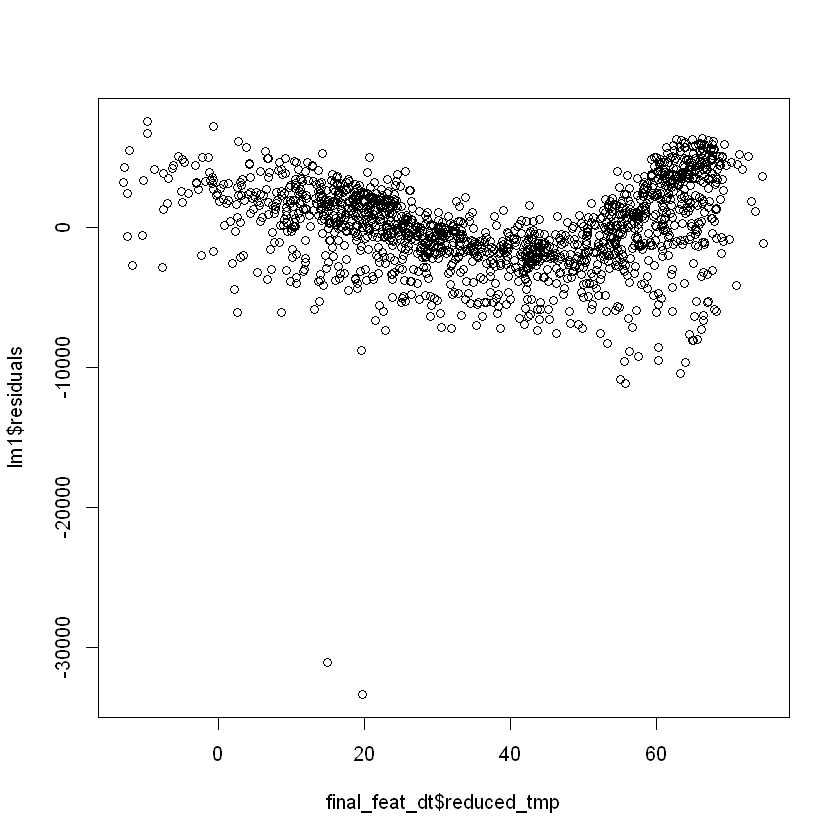

In [152]:
plot(final_feat_dt$reduced_tmp, lm1$residuals)

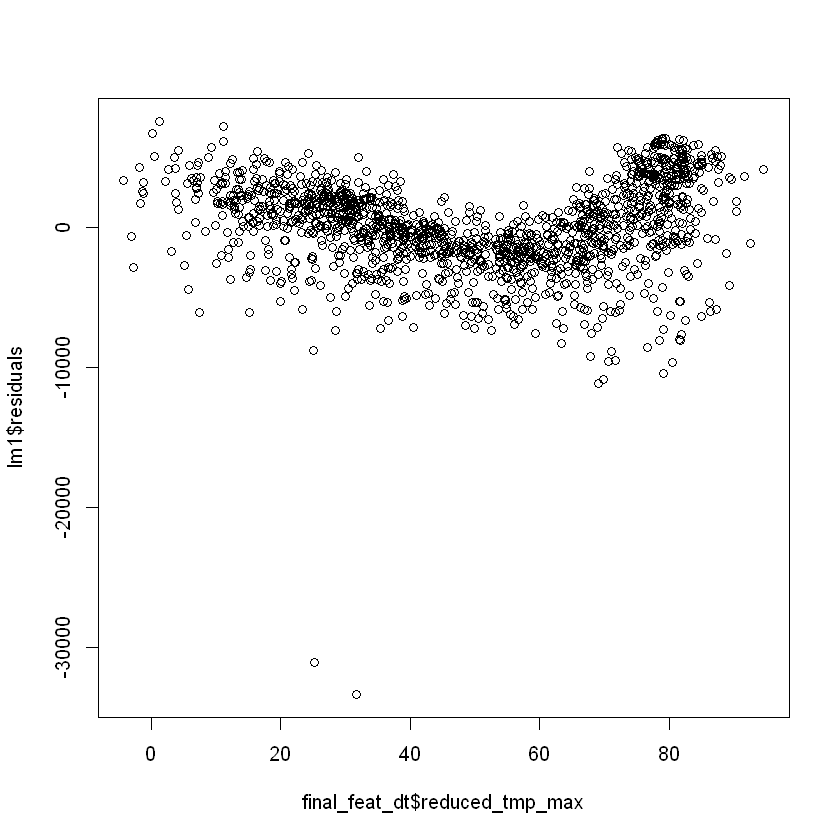

In [153]:
plot(final_feat_dt$reduced_tmp_max, lm1$residuals)

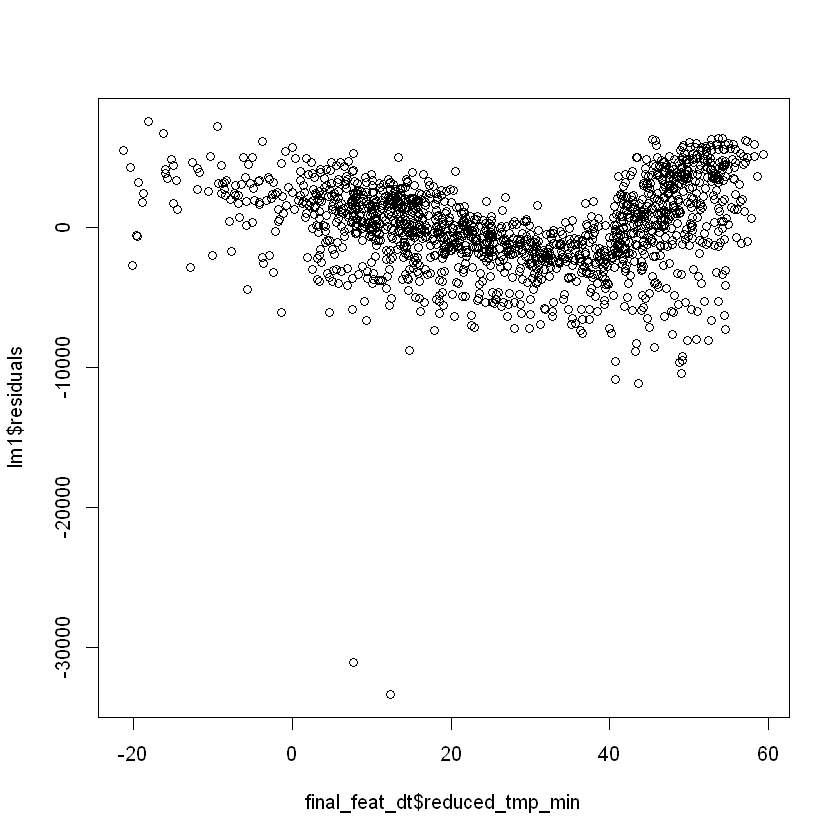

In [154]:
plot(final_feat_dt$reduced_tmp_min, lm1$residuals)

In [748]:
lm3 =lm(random~.-random-date, data=final_feat_dt[date>"2020-01-01"],)
summary(lm3)
lm3_step=step(lm3)
summary(lm3_step)

In [749]:
final_feat_dt[,abs_reduced_tmp:=abs(reduced_tmp-40)]

In [750]:
final_feat_dt[,abs_reduced_tmp_max:=abs(reduced_tmp_max-55)]

In [751]:
final_feat_dt

date,lock_down_factor,covid_severity,sunlight_time_minutes,production_capacity_rate,price_of_electricity,usdtry,reduced_tmp,reduced_tmp_max,reduced_tmp_min,abs_reduced_tmp,abs_reduced_tmp_max
2017-01-01,0,0,558,77,20.5219,3.5277,-11.8303797,5.180090,-20.1821010,51.83038,49.81991
2017-01-02,0,0,558,77,20.5219,3.5445,-7.6558338,4.145409,-14.4794818,47.65583,50.85459
2017-01-03,0,0,559,77,20.5219,3.5943,-7.5980702,10.527235,-16.0035362,47.59807,44.47276
2017-01-04,0,0,560,77,20.5219,3.5713,-0.7089871,13.484344,-11.9385991,40.70899,41.51566
2017-01-05,0,0,561,77,20.5219,3.5927,10.2108282,15.041726,4.1931925,29.78917,39.95827
2017-01-06,0,0,562,77,20.5219,3.6445,11.9315103,17.656083,4.3689798,28.06849,37.34392
2017-01-07,0,0,563,77,20.5219,3.6445,-0.6995870,3.129613,-7.6495260,40.69959,51.87039
2017-01-08,0,0,564,77,20.5219,3.6445,-7.7259978,-2.677441,-12.8573134,47.72600,57.67744
2017-01-09,0,0,565,77,20.5219,3.7129,-13.0119281,-1.134620,-19.4715034,53.01193,56.13462
2017-01-10,0,0,567,77,20.5219,3.7885,-4.9529816,3.848957,-18.9474820,44.95298,51.15104


In [752]:
# lm4=lm(random~.-random-date-consumption, data=final_feat_dt)
# summary(lm4)
# lm4_step=step(lm4)
# summary(lm4_step)

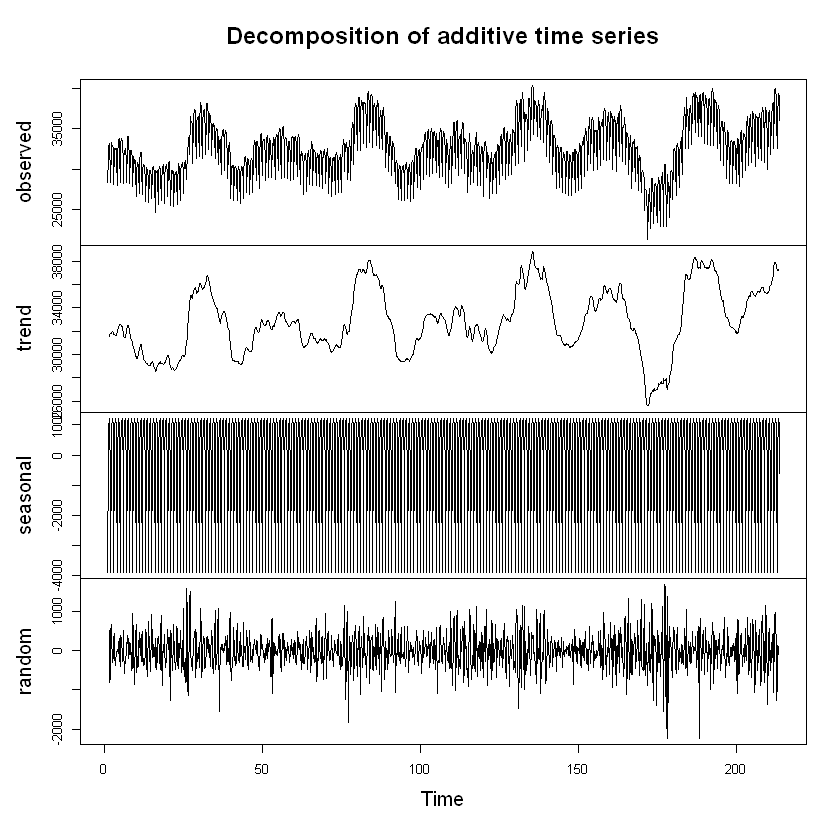

In [753]:
check_random=decompose(ts(pred_dt[date<"2021-01-31",]$consumption,freq=7),type='add')
plot(check_random)

In [754]:
final_feat_dt[, rn:=0]
final_feat_dt[date<"2021-01-31", rn:=check_random$random]

In [755]:
str(final_feat_dt)

Classes 'data.table' and 'data.frame':	1493 obs. of  13 variables:
 $ date                    : Date, format: "2017-01-01" "2017-01-02" ...
 $ lock_down_factor        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ covid_severity          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sunlight_time_minutes   : int  558 558 559 560 561 562 563 564 565 567 ...
 $ production_capacity_rate: num  77 77 77 77 77 77 77 77 77 77 ...
 $ price_of_electricity    : num  20.5 20.5 20.5 20.5 20.5 ...
 $ usdtry                  : num  3.53 3.54 3.59 3.57 3.59 ...
 $ reduced_tmp             : num  -11.83 -7.656 -7.598 -0.709 10.211 ...
 $ reduced_tmp_max         : num  5.18 4.15 10.53 13.48 15.04 ...
 $ reduced_tmp_min         : num  -20.18 -14.48 -16 -11.94 4.19 ...
 $ abs_reduced_tmp         : num  51.8 47.7 47.6 40.7 29.8 ...
 $ abs_reduced_tmp_max     : num  49.8 50.9 44.5 41.5 40 ...
 $ rn                      : num  NA NA NA 526.3 57.3 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr "date"


# Regx

In [756]:
final_feat_dt[lock_down_factor==1,lock_down_factor:=0]
final_feat_dt[lock_down_factor==2,lock_down_factor:=1]

In [757]:
str(final_feat_dt)

Classes 'data.table' and 'data.frame':	1493 obs. of  13 variables:
 $ date                    : Date, format: "2017-01-01" "2017-01-02" ...
 $ lock_down_factor        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ covid_severity          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sunlight_time_minutes   : int  558 558 559 560 561 562 563 564 565 567 ...
 $ production_capacity_rate: num  77 77 77 77 77 77 77 77 77 77 ...
 $ price_of_electricity    : num  20.5 20.5 20.5 20.5 20.5 ...
 $ usdtry                  : num  3.53 3.54 3.59 3.57 3.59 ...
 $ reduced_tmp             : num  -11.83 -7.656 -7.598 -0.709 10.211 ...
 $ reduced_tmp_max         : num  5.18 4.15 10.53 13.48 15.04 ...
 $ reduced_tmp_min         : num  -20.18 -14.48 -16 -11.94 4.19 ...
 $ abs_reduced_tmp         : num  51.8 47.7 47.6 40.7 29.8 ...
 $ abs_reduced_tmp_max     : num  49.8 50.9 44.5 41.5 40 ...
 $ rn                      : num  NA NA NA 526.3 57.3 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr "date"
 - 

In [758]:
# lm_last=lm(rn~.,data=final_feat_dt[4:1485])
# summary(lm_last)
# lm_last_step=step(lm_last)
# summary(lm_last_step)

In [759]:
elim_feat=final_feat_dt[, c("date", "lock_down_factor", "covid_severity", "sunlight_time_minutes", 
                           "production_capacity_rate", "reduced_tmp", "reduced_tmp_min",
                           'abs_reduced_tmp', "abs_reduced_tmp_max")]

In [760]:
#all_feature[,c(2,3,4,5,6,7,23,24)]

In [763]:
summary(elim_feat[,-1])

 lock_down_factor  covid_severity    sunlight_time_minutes
 Min.   :0.00000   Min.   :  0.000   Min.   :553.0        
 1st Qu.:0.00000   1st Qu.:  0.000   1st Qu.:608.0        
 Median :0.00000   Median :  0.000   Median :728.0        
 Mean   :0.02813   Mean   :  9.009   Mean   :729.1        
 3rd Qu.:0.00000   3rd Qu.:  0.000   3rd Qu.:848.0        
 Max.   :1.00000   Max.   :100.000   Max.   :908.0        
 production_capacity_rate  reduced_tmp     reduced_tmp_min  abs_reduced_tmp   
 Min.   :61.60            Min.   :-13.01   Min.   :-21.24   Min.   : 0.03416  
 1st Qu.:75.30            1st Qu.: 20.51   1st Qu.: 13.03   1st Qu.:10.72410  
 Median :76.40            Median : 37.71   Median : 27.14   Median :18.41259  
 Mean   :75.76            Mean   : 37.58   Mean   : 27.48   Mean   :18.26586  
 3rd Qu.:77.80            3rd Qu.: 57.12   3rd Qu.: 44.27   3rd Qu.:24.82887  
 Max.   :79.90            Max.   : 74.82   Max.   : 59.44   Max.   :53.01193  
 abs_reduced_tmp_max
 Min.   : 0.0

In [779]:
str(as.vector(elim_feat[date<"2021-01-28",-1]))

Classes 'data.table' and 'data.frame':	1488 obs. of  8 variables:
 $ lock_down_factor        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ covid_severity          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sunlight_time_minutes   : int  558 558 559 560 561 562 563 564 565 567 ...
 $ production_capacity_rate: num  77 77 77 77 77 77 77 77 77 77 ...
 $ reduced_tmp             : num  -11.83 -7.656 -7.598 -0.709 10.211 ...
 $ reduced_tmp_min         : num  -20.18 -14.48 -16 -11.94 4.19 ...
 $ abs_reduced_tmp         : num  51.8 47.7 47.6 40.7 29.8 ...
 $ abs_reduced_tmp_max     : num  49.8 50.9 44.5 41.5 40 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [780]:
?auto.arima

In [784]:
str(elim_feat)

Classes 'data.table' and 'data.frame':	1493 obs. of  9 variables:
 $ date                    : Date, format: "2017-01-01" "2017-01-02" ...
 $ lock_down_factor        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ covid_severity          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sunlight_time_minutes   : int  558 558 559 560 561 562 563 564 565 567 ...
 $ production_capacity_rate: num  77 77 77 77 77 77 77 77 77 77 ...
 $ reduced_tmp             : num  -11.83 -7.656 -7.598 -0.709 10.211 ...
 $ reduced_tmp_min         : num  -20.18 -14.48 -16 -11.94 4.19 ...
 $ abs_reduced_tmp         : num  51.8 47.7 47.6 40.7 29.8 ...
 $ abs_reduced_tmp_max     : num  49.8 50.9 44.5 41.5 40 ...
 - attr(*, ".internal.selfref")=<externalptr> 
 - attr(*, "sorted")= chr "date"


In [797]:
tail(pred_dt)

date,consumption
2021-01-27,38511.21
2021-01-28,39299.42
2021-01-29,39057.30
2021-01-30,35959.29
2021-01-31,-1.00
2021-02-01,-1.00


In [838]:
test_start=as.Date("2020-12-01")

results=vector("list",20)

for(i in 1:20){
    current_test_date=test_start+i
    train_data=pred_dt[date<current_test_date]
    xreg_train=unname(as.matrix(elim_feat[date<current_test_date,c(2,3,4,5,6,7,8,9)]))
    test_data=pred_dt[date==current_test_date]
    xreg_test=unname(as.matrix(elim_feat[date==current_test_date,c(2,3,4,5,6,7,8,9)]))
    decomp=decompose(ts(train_data$consumption,freq=7),type="add")
    rand_val=decomp$random  
    fit_mod=arima(rand_val, order=c(0,0,2), seasonal = list(order = c(0, 0, 1), period = 7), xreg=xreg_train)
    test_data[,forecasted:=as.numeric(predict(fit_mod, n.ahead = 1,newxreg=xreg_test)$pred + decomp$season[wday(current_test_date)] +
                                     tail(decomp$trend[!is.na(decomp$trend)],1))]
    results[[i+1]]=test_data
}

In [839]:
res_dt=rbindlist(results)

In [840]:
res_dt[, diff:=consumption-forecasted]

In [841]:
res_dt

date,consumption,forecasted,diff
2020-12-02,36928.90,36556.48,372.42098
2020-12-03,36589.02,36560.27,28.75113
2020-12-04,35920.61,36194.36,-273.74892
2020-12-05,33366.51,34488.45,-1121.94454
2020-12-06,30402.78,30977.70,-574.92423
2020-12-07,35328.13,35300.16,27.97062
2020-12-08,36755.20,36246.62,508.57753
2020-12-09,36450.95,36156.49,294.45580
2020-12-10,36355.39,36185.45,169.94104
2020-12-11,36332.31,36075.99,256.32092


In [842]:
perf_dt("Predictions in Arima with Slicing Window", res_dt$consumption, res_dt$forecasted)

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Predictions in Arima with Slicing Window,20,35199.59,2088.944,0.000835881,0.009238102,95.02083,320.9054,0.009116735
